In [2]:
pip install ucimlrepo


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_heart = fetch_ucirepo(id=145) 
  
# data (as pandas dataframes) 
X = statlog_heart.data.features 
y = statlog_heart.data.targets 
  
# metadata 
print(statlog_heart.metadata) 
  
# variable information 
print(statlog_heart.variables) 


{'uci_id': 145, 'name': 'Statlog (Heart)', 'repository_url': 'https://archive.ics.uci.edu/dataset/145/statlog+heart', 'data_url': 'https://archive.ics.uci.edu/static/public/145/data.csv', 'abstract': 'This dataset is a heart disease database similar to a database already present in the repository (Heart Disease databases) but in a slightly different form', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 270, 'num_features': 13, 'feature_types': ['Categorical', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['heart-disease'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': None, 'last_updated': 'Fri Feb 09 2024', 'dataset_doi': '10.24432/C57303', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Cost Matrix\r\n\r\n_______\t abse  pres\r\nabsence\t 0\t1\r\npresence  5\t0\r\n\r\nwhere the rows represent the true values and the columns the p

Feature Scaling and the preprocessing

In [4]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Fetch dataset
statlog_heart = fetch_ucirepo(id=145)
X = statlog_heart.data.features
y = statlog_heart.data.targets['heart-disease'].replace({1: 0, 2: 1})  # 0 = absence, 1 = presence

# Identify columns
numeric_features = ['age', 'rest-bp', 'serum-chol', 'max-heart-rate', 'oldpeak', 'major-vessels']
categorical_features = ['sex', 'fasting-blood-sugar', 'angina', 'chest-pain', 'electrocardiographic', 'slope', 'thal']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])


Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Full pipeline with logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight={0: 1, 1: 5}))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81        33
           1       0.67      0.95      0.78        21

    accuracy                           0.80        54
   macro avg       0.81      0.82      0.80        54
weighted avg       0.84      0.80      0.80        54

Confusion Matrix:
[[23 10]
 [ 1 20]]


Confusion matrix elaboration: 
True negatives (TN): 23 people without heart disease correctly predicted.

False positives (FP): 10 people without heart disease incorrectly predicted as having it.

False negatives (FN): 1 person with heart disease was missed — this is very important due to the cost.

True positives (TP): 20 people with heart disease correctly predicted.

There was only 1 false negative which is a very desirable outcome. 

The model correctly found 95% of the people who actually had heart disease.

However, about 1 out of every 3 people the model said had heart disease actually didn’t (false alarms).

Overall, the model was right 80% of the time, which is pretty good for a health-related prediction.

Feature importance

In [6]:

feature_names = (
    numeric_features +
    list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
)

# Match features to coefficients
coefs = pipeline.named_steps['classifier'].coef_[0]
feature_importance = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)

print("Top contributing features:")
print(feature_importance.head(10))


Top contributing features:
sex_1.0                    1.758673
chest-pain_4.0             1.686979
thal_7.0                   1.170336
fasting-blood-sugar_1.0   -0.811079
slope_2.0                  0.722755
major-vessels              0.625400
oldpeak                    0.604831
serum-chol                 0.421465
slope_3.0                  0.391631
rest-bp                    0.347952
dtype: float64


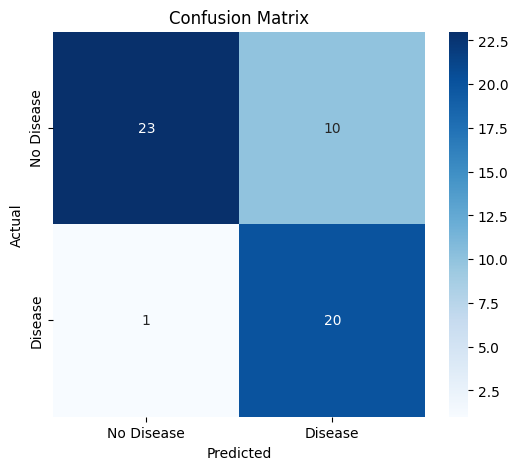

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


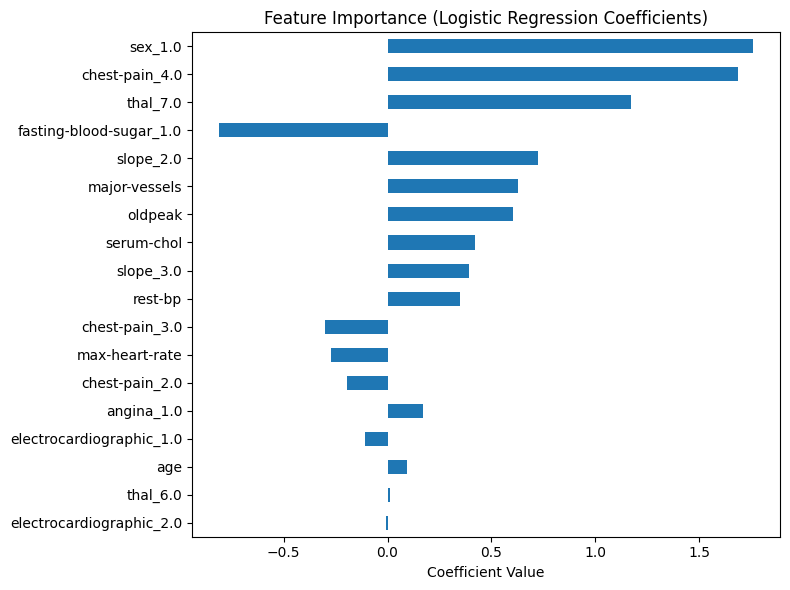

In [8]:
# Already calculated: feature_importance = pd.Series(coefs, index=feature_names)

# Sort by absolute value
feature_importance = feature_importance.sort_values(key=abs, ascending=True)

plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()


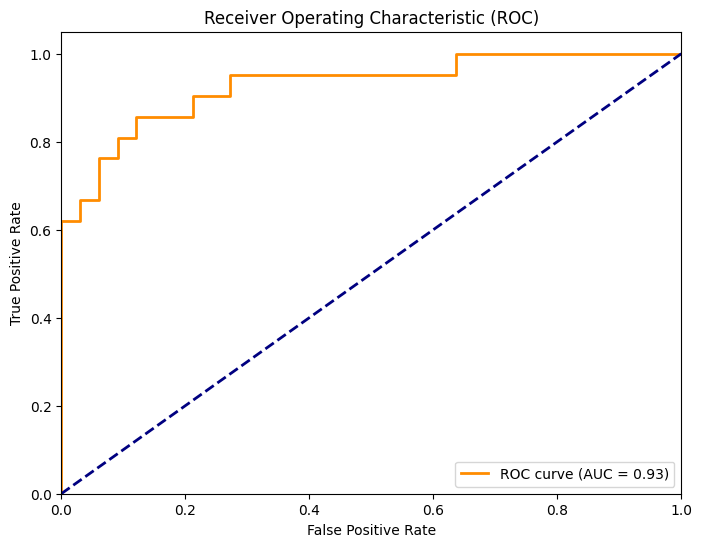

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [10]:
# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Add these plots here! ===


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81        33
           1       0.67      0.95      0.78        21

    accuracy                           0.80        54
   macro avg       0.81      0.82      0.80        54
weighted avg       0.84      0.80      0.80        54

Confusion Matrix:
[[23 10]
 [ 1 20]]
